In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os,sys
config_path = os.path.abspath(os.path.join(os.getcwd(), '..','..', 'Loading_Database'))
sys.path.append(config_path)
from configuration import *


In [ ]:
month = None  # or None
selected_airlines = ["KLM"]

In [2]:

AIRLINE_USER_IDS = {
    56377143: 'KLM',
    106062176: 'AirFrance',
    18332190: 'British_Airways',
    22536055: 'AmericanAir',
    124476322: 'Lufthansa',
    26223583: 'AirBerlin',
    2182373406: 'AirBerlin assist',
    38676903: 'easyJet',
    1542862735: 'RyanAir',
    253340062: 'Singapore'
}

SENTI_MAP = {
    "Very Negative": 0.0,
    "Negative": 0.25,
    "Neutral": 0.5,
    "Positive": 0.75,
    "Very Positive": 1.0
}

def load_data(month=None, airlines=None):
    conn = psycopg2.connect(DATABASE_URL)
    query = """
        SELECT 
            c.id AS conv_id,
            c.position,
            c.airline_names,
            t.id AS tweet_id,
            t.created_at,
            t.user_id,
            t.senti_raw_tabularis
        FROM conversations c
        JOIN tweets t ON c.tweet_id = t.id
        WHERE c.airline_involved = TRUE
    """
    df = pd.read_sql(query, conn)
    conn.close()

    df['created_at'] = pd.to_datetime(df['created_at'])

    def extract_score(raw):
        try:
            parsed = ast.literal_eval(raw)
            label = parsed.get('label')
            weight = SENTI_MAP.get(label, None)
            return weight
        except:
            return None
    #
    df['senti_score'] = df['senti_raw_tabularis'].apply(extract_score)

    if month:
        df = df[df['created_at'].dt.strftime('%Y-%m') == month]

    if airlines:
        airline_ids = [uid for uid, name in AIRLINE_USER_IDS.items() if name in airlines]
        df['airline_names'] = df['airline_names'].apply(lambda x: ast.literal_eval(x) if x.startswith('[') else [x])
        df = df[df['airline_names'].apply(lambda lst: any(a in lst for a in airlines))]
        df = df[df['user_id'].isin(airline_ids + list(df['user_id'].unique()))]

    return df


In [3]:

def prepare_reply_delay_sentiment_change(df):
    results = []
    for conv_id, group in df.groupby('conv_id'):
        group = group.sort_values('position')
        group['user_type'] = group['user_id'].apply(lambda uid: AIRLINE_USER_IDS.get(uid, 'user'))
        user_msgs = group[group['user_type'] == 'user']
        airline_msgs = group[group['user_type'] != 'user']
        if user_msgs.empty or airline_msgs.empty:
            continue
        avg_score_no_airlines = user_msgs['senti_score'].mean()
        if pd.isna(avg_score_no_airlines):
            continue
        delay_sec = (airline_msgs.iloc[0]['created_at'] - user_msgs.iloc[0]['created_at']).total_seconds()
        if delay_sec < 0 or delay_sec > 86400 * 7:  # skip if >7 days or negative
            continue
        delay = delay_sec / 60
        sentiment_delta = avg_score_no_airlines 
        results.append({
            "conv_id": conv_id,
            "airline": group[group['user_id'] == airline_msgs.iloc[0]['user_id']]['user_type'].iloc[0],
            "delay_minutes": delay,
            "sentiment_change": sentiment_delta
        })
    return pd.DataFrame(results)

def plot_reply_delay_vs_sentiment(df_delay):
    if df_delay.empty:
        print("No valid data to plot.")
        return
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_delay, x='delay_minutes', y='sentiment_change', hue='airline', alpha=0.6)
    sns.regplot(data=df_delay, x='delay_minutes', y='sentiment_change', scatter=False, color='black')
    plt.axhline(0, linestyle='--', color='gray')
    plt.title("Reply Delay vs. avg. Sentiment of user replies")
    plt.xlabel("Reply Delay (minutes) (first airline reply in a conversation)")
    plt.ylabel("avg. Sentiment of user replies in a conv/")
    plt.tight_layout()
    plt.show()


C:\Users\pavel\AppData\Local\Temp\ipykernel_5816\1565221935.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\pavel\AppData\Local\Temp\ipykernel_5816\1565221935.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'])


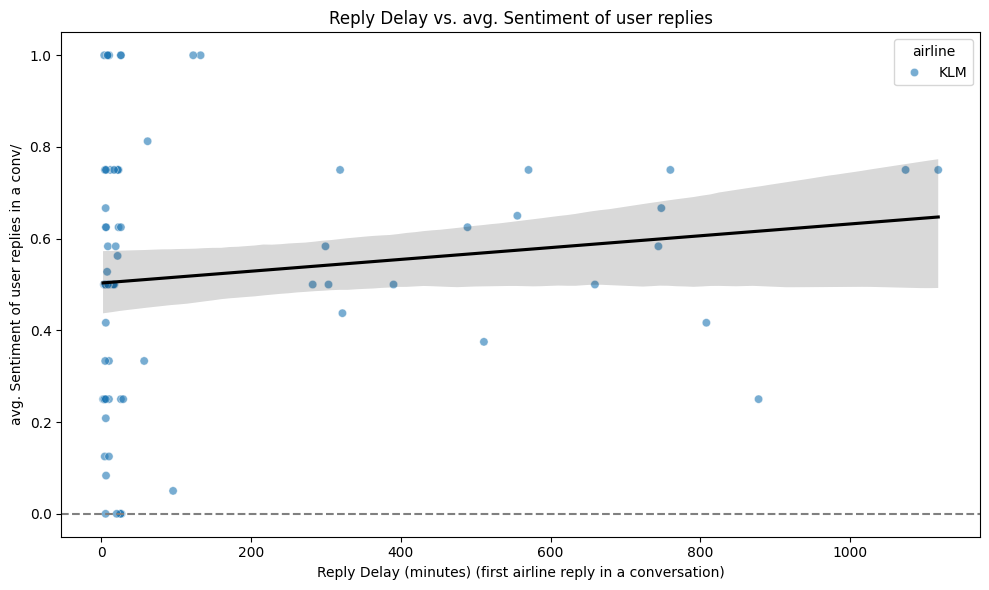

In [ ]:

df_all = load_data(month=month, airlines=selected_airlines)
df_delay = prepare_reply_delay_sentiment_change(df_all)
plot_reply_delay_vs_sentiment(df_delay)
